In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import utils

In [2]:
Res_1 = utils.RetrievalResults(prefix='../retrieval_outputs/no_bands_K_B_ret_6/test_')
_, flux_global, Rot_1     = Res_1.get_model_spec(is_local=False)
wave_local, flux_local, _ = Res_1.get_model_spec(is_local=True)
rv, CCF, CCF_SNR_1 = Res_1.get_CCF(
    wave_local, flux_local, flux_global, 
    subtract_global=True, 
    )

Res_2 = utils.RetrievalResults(prefix='../retrieval_outputs/eq_band_K_B_ret_2/test_')
#Res_2 = utils.RetrievalResults(prefix='../retrieval_outputs/spot_K_B_ret_16/test_')
_, flux_global, Rot_2     = Res_2.get_model_spec(is_local=False)
wave_local, flux_local, _ = Res_2.get_model_spec(is_local=True)
rv, CCF, CCF_SNR_2 = Res_2.get_CCF(
    wave_local, flux_local, flux_global, 
    subtract_global=True, 
    )

Res_3 = utils.RetrievalResults(prefix='../retrieval_outputs/spot_K_B_ret_19/test_')
_, flux_global, Rot_3     = Res_3.get_model_spec(is_local=False)
wave_local, flux_local, _ = Res_3.get_model_spec(is_local=True)
rv, CCF, CCF_SNR_3 = Res_3.get_CCF(
    wave_local, flux_local, flux_global, 
    subtract_global=True, 
    )

*_, Rot_3_spot = Res_3.get_model_spec(is_local=False, m_set='K2166_spot')
Res_3.add_patch_to_Rot(Rot_3, Rot_3_spot)

  analysing data from ../retrieval_outputs/no_bands_K_B_ret_6/test_.txt


100%|██████████| 1201/1201 [00:05<00:00, 214.88it/s]


  analysing data from ../retrieval_outputs/eq_band_K_B_ret_2/test_.txt


100%|██████████| 1201/1201 [00:05<00:00, 239.96it/s]


  analysing data from ../retrieval_outputs/spot_K_B_ret_19/test_.txt


100%|██████████| 1201/1201 [00:05<00:00, 237.68it/s]


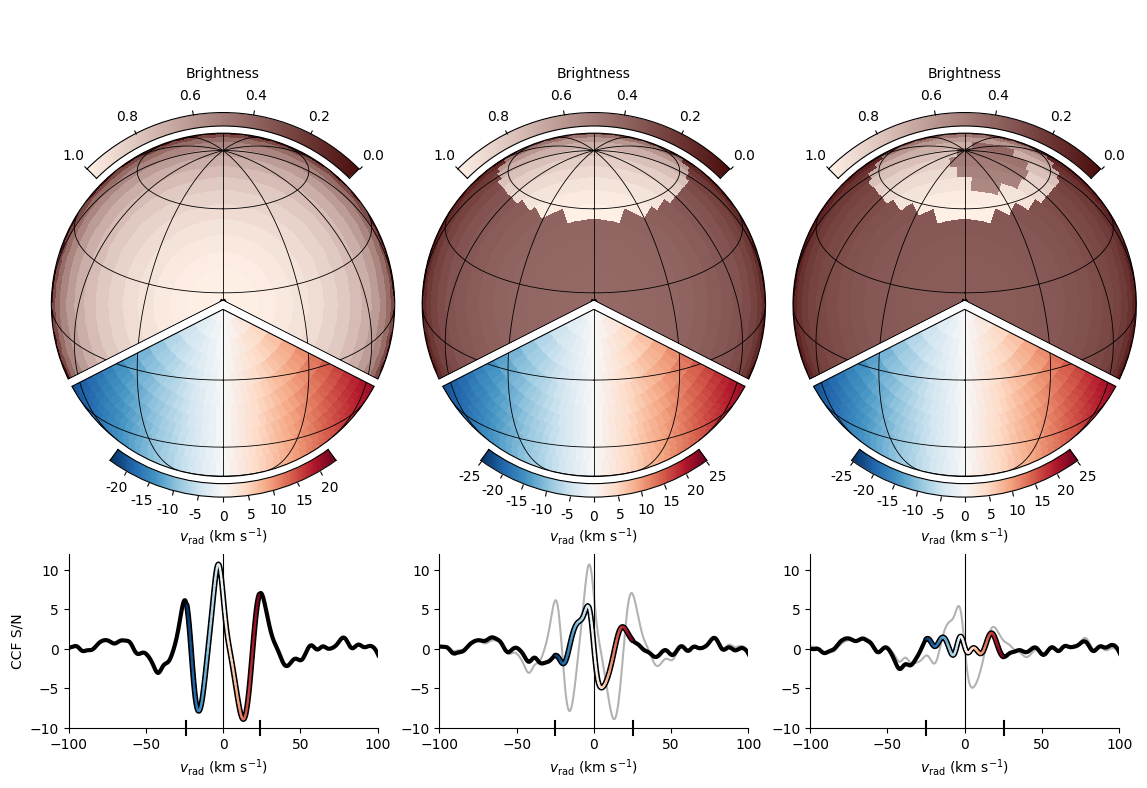

In [3]:
shrink = 0.9
cmap = utils.get_cmap()

old_CCF_i = None

fig = plt.figure(figsize=(14,8))
gs = fig.add_gridspec(nrows=2, ncols=3, hspace=0.2, wspace=0.08, height_ratios=[1,0.45])

ax = []; cax = []; ax_CCF = []

iterables = zip(
    [Rot_1, Rot_2, Rot_3], [Res_1, Res_2, Res_3], 
    [CCF_SNR_1, CCF_SNR_2, CCF_SNR_3]
    )
for i, (Rot_i, Res_i, CCF_i) in enumerate(iterables):

    vsini_i = Res_i.bestfit_params['K2166_cloudy']['vsini']

    # --- Brightness map --------------------------------
    ax_i  = fig.add_subplot(gs[0,i], projection='polar')
    cax_i = fig.add_subplot(gs[0,i], projection='polar')

    sphere = utils.SpherePlot(Rot_i, fig, ax_i, cax_i)
    sphere.plot_map(
        attr='int_flux', cmap=cmap, edgecolors='face', lw=1e-6, 
        )
    sphere.configure_ax(
        xlim=np.pi/2 + 1/2*1.3*np.pi*np.array([-1,1]), 
        sep_spine_lw=5, grid_lw=0.6
        )
    sphere.configure_cax(
        label='Brightness', xlim=(1/4*np.pi,3/4*np.pi), cb_width=0.07, scale=1.12, flip_cb=True, 
        xticks=[0.0,0.2,0.4,0.6,0.8,1.0], vmin=0., vmax=1., cmap=cmap
        )
    ax.append(ax_i); cax.append(cax_i)
    
    # --- Velocity map ----------------------------------
    ax_i  = fig.add_subplot(gs[0,i], projection='polar')
    cax_i = fig.add_subplot(gs[0,i], projection='polar')
    sphere = utils.SpherePlot(Rot_i, fig, ax_i, cax_i)
    sphere.plot_map(
        attr='v_grid', cmap='RdBu_r', edgecolors='face', lw=1e-6, 
        )
    sphere.configure_ax(
        xlim=-np.pi/2 + 1/2*(2-1.3)*np.pi*np.array([-1,1]), 
        sep_spine_lw=5, grid_lw=0.6
        )
    sphere.configure_cax(
        label=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', 
        xlim=(-np.pi/2-np.pi/5,-np.pi/2+np.pi/5), cb_width=0.07, scale=1.12, 
        xticks=np.arange(-25,25+1,5), vmin=-vsini_i, vmax=vsini_i, cmap='RdBu_r'
        )
    ax.append(ax_i); cax.append(cax_i)

    # --- Cross-correlation -----------------------------
    ax_CCF_i = fig.add_subplot(gs[1,i])

    ylabel = None
    if i == 0:
        ylabel = 'CCF S/N'
    CC = utils.CrossCorrPlot(fig, ax_CCF_i, vsini=vsini_i)
    CC.plot(rv, CCF_i, old_CCF_i, lw=3, c='k', plot_colorbar=False)
    CC.configure_ax(ylabel=ylabel, ylim=(-10,12), xlim=(-100,100))
    CC.add_xtick_at_vsini()

    # Shrink the CCF axis
    l, b, w, h = ax_CCF_i.get_position().bounds
    ax_CCF_i.set_position([l + (1-shrink)*w/2, b, w*shrink, h])

    old_CCF_i = CCF_i.copy()

    ax_CCF.append(ax_CCF_i)

# Create a tighter bounding box to save the figure
l, b, *_ = ax_CCF[0].get_position().bounds
r = ax_CCF[-1].get_position().bounds[0] + ax_CCF[-1].get_position().bounds[2]
t = cax[0].get_position().bounds[1] + cax[0].get_position().bounds[3]

l, r, b, t = np.array([l, r, b, t]) + np.array([-0.055,0.02,-0.07,-0.05])

l, r = np.array([l, r]) * fig.get_size_inches()[0]
b, t = np.array([b, t]) * fig.get_size_inches()[1]
bbox = mpl.transforms.Bbox([[l,b],[r,t]])

plt.savefig('./plots/surface_comparison_B.pdf', bbox_inches=bbox)
plt.show()